# Космический корабль Титаник

[Spaceship Titanic: predict which passengers are transported to an alternate dimension](https://www.kaggle.com/competitions/spaceship-titanic/)  

Задача взята из соревнования на kaggle для начинающих. Представляет собой классическую бинарную классификацию по мотивам известного датасета Titanic.  

Суть датасета и задачи заключается в следующем: космический корабль Титаник, двигавшийся к далёким звездным системам, попал в пространственно-временную аномалию, вследствие чего половина пассажиров попали в альтернативную реальность. По данным бортового компьютера **необходимо предсказать, попал ли тот или иной пассажир в эту самую параллельную реальность**, тем самым облегчив спасательную операцию.  

Данные представлены двумя файлами. В файле `train.csv` представлена информация о 8693 пассажирах в 14 колонках. В файле `test.csv` представлена информация о 4277 пассажирах с теми же колонками, но без целевой переменной. Собственно эти тестовые данные и нужно классифицировать, отправив на странице соревнования файл `submission.csv` с двумя колонками: `PassengerId` и `Transported`.  

**Описание** датасета:  

* `PassengerId` - Уникальный идентификатор пассажира, состоящий из двух частей `gggg_pp`, где `gggg` - это номер группы пассажира, а `pp` - номер самого пассажира в группе, люди в одной группе могут быть связаны, например, родством.  
* `HomePlanet` - Планета, с которой пассажир отбыл.  
* `CryoSleep` - Был ли пассажир в состоянии анабиоза.  
* `Cabin` - Номер каюты пассажира, состоит из трёх частей `deck/num/side` - палуба/номер/сторона, где сторона может быть или `P` для левого борта или `S` для правого.  
* `Destination` - Планета назначения, куда летит пассажир.  
* `Age` - Возраст.  
* `VIP` - Заплатил ли пассажир за VIP услуги.  
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Сколько заплатил пассажир за те или иные роскошные удобства.  
* `Name` - Имя и фамилия.  
* `Transported` - Был ли пассажир отправлен в альтернативное измерение. Это **целевая переменная**.  

## Подготовка  

### Настройка ноутбука

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Импорт библиотек  

In [2]:
from os.path import join as path_join
from functools import partial
from typing import NamedTuple, Sequence, Hashable

import pandas as pd
import numpy as np
import numpy.typing as npt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.base import BaseEstimator
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Установка констант  

In [3]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_FOLDS = 6
TARGET = 'Transported'

### Загрузка данных  

In [4]:
train_dataset = pd.read_csv(path_join('data', 'train.csv'))
test_dataset = pd.read_csv(path_join('data', 'test.csv'))

print('Размер тренировочного датасета:', train_dataset.shape)
print('Размер тестового датасета:', test_dataset.shape)

train_dataset.head()

Размер тренировочного датасета: (8693, 14)
Размер тестового датасета: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## EDA - разведочный анализ данных  

### Гипотезы  

* Имя и фамилия вряд ли будут полезны.  
* Пассажиры, бывшие в анабиозе, в большей степени были транспортированы в другое измерение.  

### Основная информация о датасете и признаках  

In [5]:
data = train_dataset.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
data.describe(include=['object', 'bool'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall,True
freq,1,4602,5439,8,5915,8291,2,4378


### Целевая переменная  

Целевая переменная `Transported` распределена равномерно.  

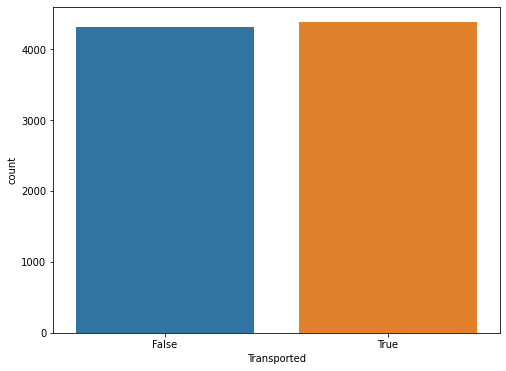

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(x='Transported', data=data)
plt.show()

Зависимость целевой переменной от денег, потораченных на борту: какой-то однозначной зависимости не наблюдается.

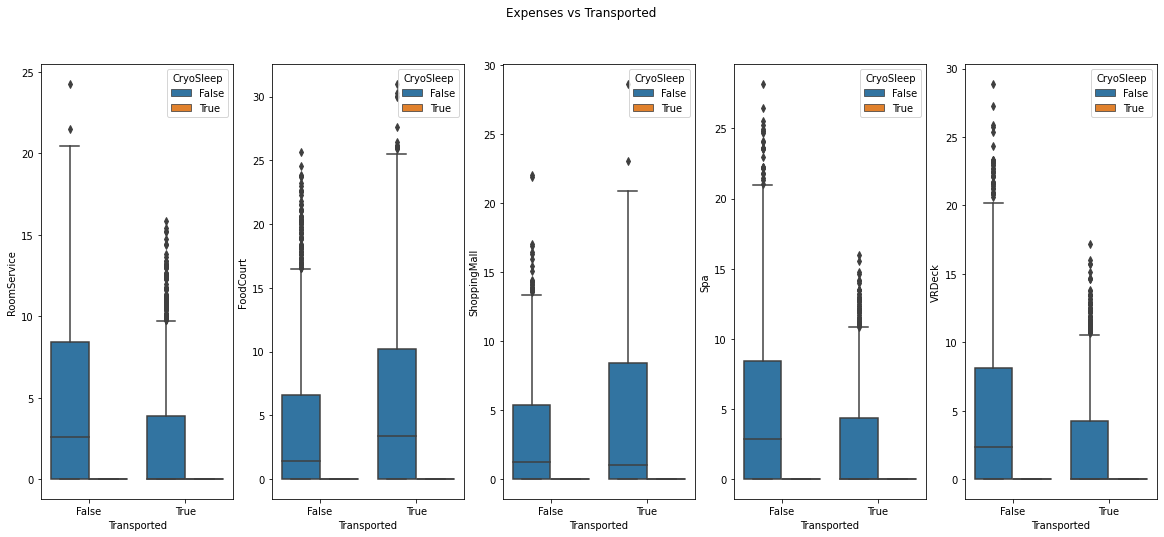

In [10]:
numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
figure, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), sharey=False, figsize=(20, 8))
figure.suptitle('Expenses vs Transported')

for i, column in enumerate(numerical_columns):
    sns.boxplot(y=data[column]**(1/3), x=data[TARGET], ax=axes[i], hue=data['CryoSleep'])

### Более подробно  

`PassengerId`: данные в этой колонке составлены из двух чисел: номер группы и номер самого пассажира. Что если их разделить на `PassengerGroup` и `PassengerNumber`?  

In [11]:
data[['PassengerGroup', 'PassengerNumber']] = data['PassengerId'].str.split('_', expand=True)

data[['PassengerGroup', 'PassengerNumber']].astype(float).describe()

,PassengerGroup,PassengerNumber
count,8693.000000,8693.000000
mean,4633.389624,1.517773
std,2671.028856,1.054241
min,1.000000,1.000000
25%,2319.000000,1.000000
50%,4630.000000,1.000000
75%,6883.000000,2.000000
max,9280.000000,8.000000


`Name`: стоит ли как-то использовать имена? Уникальных значений имен и фамилий слишком много и маловероятно, что они будут полезны. Создать из них новые признаки сложно. От имён просто избавимся.  

In [12]:
data['FirstName'] = data['Name'].apply(lambda x: None if pd.isna(x) else x.split()[0])
data['LastName'] = data['Name'].apply(lambda x: None if pd.isna(x) else x.split()[1])

data[['FirstName', 'LastName']].describe()

,FirstName,LastName
count,8493,8493
unique,2706,2217
top,Idace,Casonston
freq,13,18


`Cabin`: если разделить данные в колонке, можно получить вполне полезные признаки.  
Пропуски в `CabinDeck` и `CabinSide` можно заполнить самым частым значением, а пропуски в `CabinNumber` неудобно заполнить ни средним, ни самым частым значением поэтому заполним его новым значением - тем, что больше макисмального на 1.  

In [13]:
data['CabinDeck'] = data['Cabin'].apply(lambda x: None if pd.isna(x) else x.split('/')[0])
data['CabinNumber'] = data['Cabin'].apply(lambda x: None if pd.isna(x) else x.split('/')[1])
data['CabinSide'] = data['Cabin'].apply(lambda x: None if pd.isna(x) else x.split('/')[2])

max_num = data['CabinNumber'].dropna().astype(int).max()
print('Максимальное значение в CabinNumber:', max_num)
data[['CabinDeck', 'CabinNumber', 'CabinSide']].describe()

Максимальное значение в CabinNumber: 1894


,CabinDeck,CabinNumber,CabinSide
count,8494,8494,8494
unique,8,1817,2
top,F,82,S
freq,2794,28,4288


`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: может оказаться полезным признак всех трат `TotalExpenses`. Этот новый признак показывает, что половина пассажиров так или иначе тратят деньги. Больше всего денег тратится на еду, а меньше всего на спа.

In [14]:

columns_for_summing = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
data['TotalExpenses'] = data[columns_for_summing].fillna(0.0).sum(axis=1)   

data[columns_for_summing + ['TotalExpenses']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791,1440.866329
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000,1441.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


`Age`: какоё-то значительной разницы в возрасте между транспортированными в иное измерение и нет, не наблюдается. Зато наблюдаются выбросы для возрастов >65.

<AxesSubplot:xlabel='Transported', ylabel='Age'>

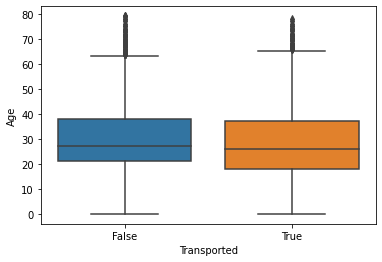

In [15]:
sns.boxplot(y=data['Age'], x=data['Transported'])

### Корреляции  

Из корреляций может быть интересно:  
* между `CryoSleep` и `Transported`;  
* между `CabinNumber` и `PassengerGroup` - и в целом зависимость понятна: пассажиры одной группы часто родственники, которые и занимают общую кабину.  

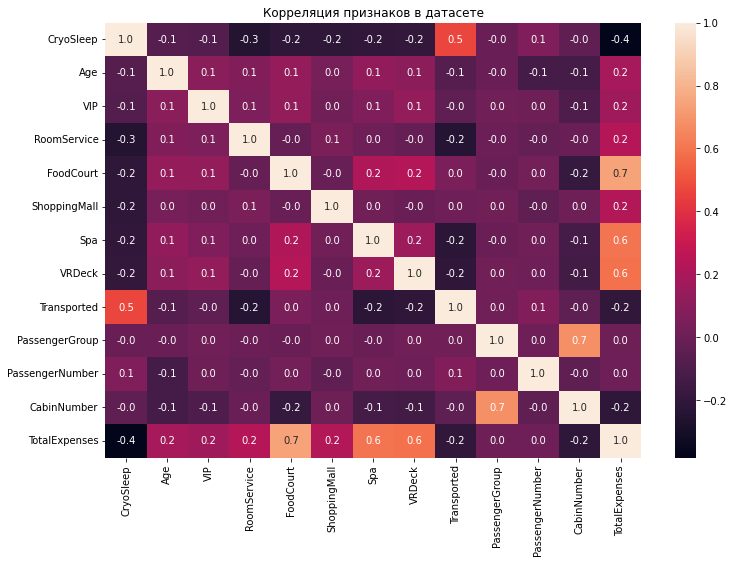

In [16]:
for column in data.drop(columns=['PassengerId']).columns:
    data[column] = data[column].astype(float, errors='ignore')

plt.figure(figsize=(12, 8))
plt.title('Корреляция признаков в датасете')
sns.heatmap(data.corr(), annot=True, fmt='0.1f')
plt.show()

Корреляция между `CryoSleep` и `Transported`:  
* большинство пассажиров в анабиозе были транспортированы в другое измерение;  
* те, кто не был в анабиозе, по большей части спаслись.  

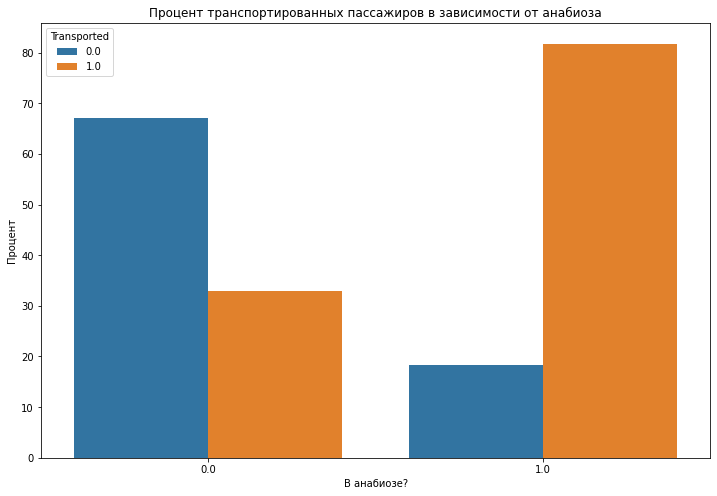

In [17]:
cryosleep_transported = (
    data.groupby(['CryoSleep'])['Transported']
    .value_counts(normalize=True)
    .rename('Percentage')
    .mul(100)
    .reset_index()
    .sort_values('CryoSleep'))

plt.figure(figsize=(12, 8))
plt.title('Процент транспортированных пассажиров в зависимости от анабиоза')
sns.barplot(x='CryoSleep', y='Percentage', hue='Transported', data=cryosleep_transported)
plt.xlabel('В анабиозе?')
plt.ylabel('Процент')
plt.show()

### Выбросы  

Взлянем на возможные выбросы в численных признаках. Выбросов много, избавлюсь от них, взяв корень от значений.

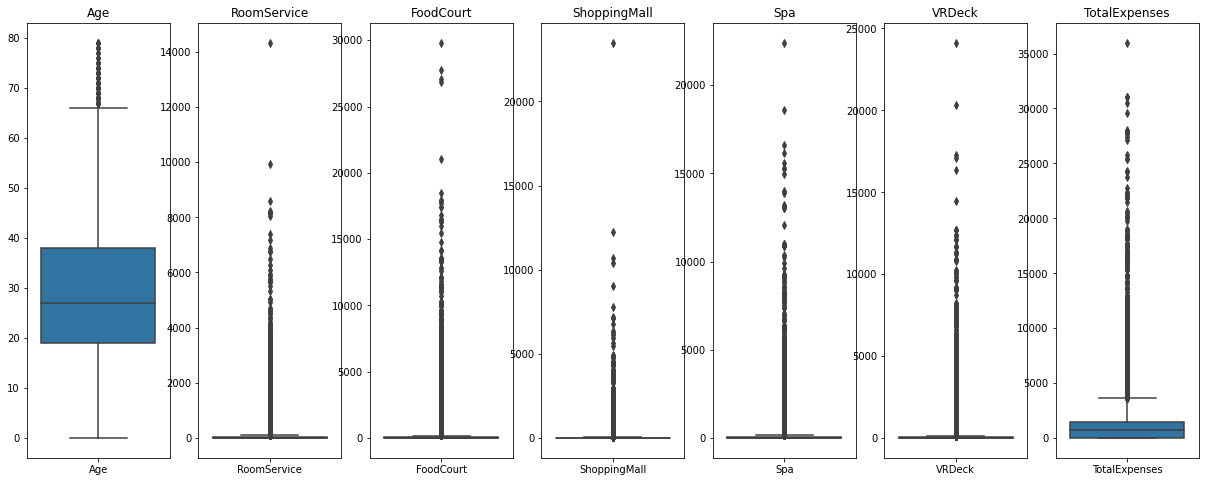

In [18]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalExpenses']

fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(3*len(numerical_columns), 8))
for i, column in enumerate(numerical_columns):
    to_show = data[[column]]
    sns.boxplot(data=to_show, ax=axes[i])
    axes[i].set_title(column)

## Data Preparation  

Преобразование данных будет проводиться через pipeline библиотеки sklearn.  

In [19]:
class DataFrameColumnTransformer(ColumnTransformer): 
    """Кастомный трансформер колонок, который возвращает pd.DataFrame, а не массив numpy."""

    def get_names(self) -> list[str]:
        names = self.get_feature_names_out()
        names = [n.split('__')[-1] for n in names]
        return names

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        result = super().transform(X)
        names = self.get_names()
        for i, name in enumerate(names):
            X[name] = result[:, i]
            X[name] = X[name].astype(float, errors='ignore')
        return X
    
    def fit_transform(self, X: pd.DataFrame, y: pd.Series | None = None) -> pd.DataFrame:
        result = super().fit_transform(X, y)
        names = self.get_names()
        for i, name in enumerate(names):
            X[name] = result[:, i]
            X[name] = X[name].astype(float, errors='ignore')
        return X

### Разделение колонок  

Информация в некоторых колонках содержит больше одного признака. Их стоит разделить.  
Колонку `PassengerId` можно разделить на группу `PassengerGroup` и номер пассажира `PassengerNumber`.  
Колонку `Cabin` можно разделить на палубу `CabinDeck`, номер `CabinNumber` и сторону `CabinSide`.  
Колонку `Name` можно было бы разделить, но она бесполезна.

In [20]:
def separate_columns(data: pd.DataFrame) -> pd.DataFrame:
    """Разделяет колонки, в которых много значений:
    * `PassengerId` -> `PassengerGroup` и `PassengerNumber`; 
    * `Cabin` -> `CabinDeck`, `CabinNumber` и `CabinSide`; 
    """

    data = data.copy()

    data[['PassengerGroup', 'PassengerNumber']] = data['PassengerId'].str.split('_', expand=True)
    data[['CabinDeck', 'CabinNumber', 'CabinSide']] = data['Cabin'].str.split('/', expand=True)

    columns_to_float = ['PassengerGroup', 'PassengerNumber', 'CabinNumber']
    data[columns_to_float] = data[columns_to_float].astype(float)

    return data

columns_separator = FunctionTransformer(separate_columns)

### Заполнение пропусков  

Во всех колонках, кроме id пассажира и целевой переменной, есть пропуски.  
Пропуски в колонке `Age` можно заполнить средним значением.  
Пропуски в колонках `HomePlanet`, `CryoSleep`, `Destination`, `VIP`, `CabinDeck`, `CabinSide` можно заполнить самым частым значением.  
Пропуски в колонках `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` можно заполнить 0, как самым частым значением и мединой.
Пропуски в колонке `CabinNumber` можно заполнить новым значением, большим максимального на 1.  

In [21]:
class MaxMoreImputer(BaseEstimator, TransformerMixin):
    """Класс для заполнения пропущенных значений. 
    Пустые значения заполняются максимальным значением колонки, увеличенных на значение `step`.
    """

    def __init__(self, step: float = 1.0) -> None:
        super().__init__()
        self.step = step
        self._features_names = None
        self._impute_value = None
    
    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike | None = None) -> 'MaxMoreImputer':
        self._impute_value = X.astype(float).max()
        self._features_names = X.columns
        return self
    
    def transform(self, X: npt.ArrayLike, y: npt.ArrayLike | None = None) -> np.ndarray:
        check_is_fitted(self, '_impute_value')
        return X.fillna(self._impute_value + self.step)
    
    def get_feature_names_out(self, input_features: npt.ArrayLike | None = None) -> np.ndarray:
        check_is_fitted(self, '_features_names')
        return self._features_names

In [22]:
missings_filler = DataFrameColumnTransformer(transformers=[
    ('age_imputer', SimpleImputer(strategy='mean'), ['Age']), 
    ('mode_imputer', SimpleImputer(strategy='most_frequent'), 
     ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']), 
    ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0.0), 
     ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']), 
    ('cabin_number_imputer', MaxMoreImputer(), ['CabinNumber']), 
], remainder='passthrough')

### Feature Engineering  

Можно создать признак `AgeCategory`, показывающий возрастную группу пассажира.  
Также было бы неплохо создать признак, содержащий общую сумму трат `TotalExpenses`.  
Для численных признаков можно добавить такие характеристики как квадратный корень, квадрат и т.д.

In [23]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    """Создаёт новые признаки: 
    * `AgeCategory` в качестве уровня возраста;
    * `TotalExpenses` как сумма `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` и `VRDeck`;
    * `ExpensesCategory` для определения нищих и мажоров;
    * Новые численные признаки из старых.
    """

    data = data.copy()

    def get_age_category(age: float) -> str: 
        categories = ['child', 'young', 'average', 'old']
        number = int(age > 20) + int(age > 40) + int(age > 60)
        return categories[number]
    data['AgeCategory'] = data['Age'].apply(get_age_category)

    columns_for_summation = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    data['TotalExpenses'] = data[columns_for_summation].sum(axis=1)    

    def get_expenses_category(expenses: float) -> str: 
        categories = ['zero', '<2500', '<7500', '>7500']
        number = int(expenses > 0) + int(expenses > 2500) + int(expenses > 7500)
        return categories[number]
    data['ExpensesCategory'] = data['TotalExpenses'].apply(get_age_category)

    numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'TotalExpenses']
    data[['Sqrt' + c for c in numerical_columns]] = data[numerical_columns] ** 0.5
    data[['Pow2' + c for c in numerical_columns]] = data[numerical_columns] ** 2
    data[['SqrtSqrt' + c for c in numerical_columns]] = data[numerical_columns] ** 0.25
    data[['Pow4' + c for c in numerical_columns]] = data[numerical_columns] ** 4
    
    return data

features_creator = FunctionTransformer(create_features)

### Нормализация и one-hot кодирование

Нормализация осуществляется с помощью StandardScaler, а кодирование - с помощью OneHotEncoder.

In [24]:
normalizer_encoder = DataFrameColumnTransformer(transformers=[
    ('scaler', StandardScaler(), make_column_selector(dtype_include=float)),
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
], remainder='passthrough')

### Удаление ненужных колонок  



In [25]:
def remove_columns(data: pd.DataFrame, columns: Hashable | Sequence[Hashable] | pd.Index | None = None) -> pd.DataFrame:
    """Удаляет ненужные колонки, по умолчанию:  
    
    `PassengerId`, `HomePlanet`, `Cabin`, `Destination`, `Name`,  
    `CabinDeck`, `CabinSide`, `AgeCategory`, `ExpensesCategory`.
    """

    data = data.copy()

    columns = columns or ['PassengerId', 'Cabin', 'Name', 'HomePlanet', 'Destination', 
                          'CabinDeck', 'CabinSide', 'AgeCategory', 'ExpensesCategory'] 
    data = data.drop(columns=columns, errors='ignore')

    return data

# Удалим Cabin и Name заранее, чтобы они не попали в one-hot encoder
remove_cabin_name = partial(remove_columns, columns=['Cabin', 'Name'])
cabin_name_remover = FunctionTransformer(remove_cabin_name)
columns_remover = FunctionTransformer(remove_columns)

### Сборка пайплайна  

Соберём все запланированные шаги подготовки данных в единый пайплайн.  

In [26]:
preprocessor = Pipeline(steps=[
    ('columns_separation', columns_separator), 
    ('filling_missing', missings_filler), 
    ('feature_engineering', features_creator), 
    ('cabin_name_removing', cabin_name_remover), 
    ('normalization_encoding', normalizer_encoder), 
    ('feature_selection', columns_remover), 
])

## Modeling  

### Разделение данных  

Отделим целевую переменную от датасета. Разделять на тренировочную и тестовые выборки смысла нет, так как везде используется кросс-валидация. Данные сразу подготовим с целью улучшения производительности.  

In [27]:
x = train_dataset.copy()
y = x.pop(TARGET)

x = preprocessor.fit_transform(x)
x_test = preprocessor.transform(test_dataset)

print(f'x, y shapes: {x.shape}, {y.shape}')
print(f'x_test shape: {x_test.shape}')

x, y shapes: (8693, 64), (8693,)
x_test shape: (4277, 64)


### Выбор метрик  

Так как это классификация и целевая переменная распределена равномерно, будем использовать в качестве основной метрики точность - `accuracy_score`. Но также взглянем и на другие метрики: precision, recall, f1, roc-auc.

In [28]:
class Metrics(NamedTuple):
    """Класс для сохранения и передачи информации о метриках."""
    
    accuracy: float
    precision: float
    roc_auc: float
    recall: float
    f1: float

    @classmethod
    def names(cls) -> tuple[str, ...]:
        return cls._fields

In [29]:
def get_metrics(cv_results: dict[str, npt.NDArray[np.float64]]) -> Metrics:
    """Возвращает метрики из результатов кросс-валидации."""

    metrics = {m: cv_results['test_' + m].mean() for m in Metrics.names()}
    
    return Metrics(**metrics)

In [30]:
metrics = pd.DataFrame(columns=Metrics.names())

### Базовая модель  

В качестве базовой модели возьмём ту, что случайно выбирает ответ.

In [31]:
baseline = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
cv_results = cross_validate(baseline, x, y, cv=N_FOLDS, scoring=Metrics.names())

metrics.loc['baseline', :] = get_metrics(cv_results)
metrics

,accuracy,precision,roc_auc,recall,f1
baseline,0.499482,0.503102,0.5,0.499769,0.50143


### Выбор модели  

Обучим несколько моделей с параметрами по умолчанию, выберем лучшую из них и уже её будем оптимизировать далее.  

In [32]:
models = [
    ('random_forest', RandomForestClassifier(random_state=RANDOM_STATE)), 
    ('gradient_boosting', GradientBoostingClassifier(random_state=RANDOM_STATE)), 
    ('logistic_regression', LogisticRegression(solver='liblinear')), 
    ('svc', SVC(random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier()), 
    ('ridge', RidgeClassifier(random_state=RANDOM_STATE)), 
]

for name, model in models:
    cv_results = cross_validate(model, x, y, cv=N_FOLDS, scoring=Metrics.names())
    metrics.loc[name, :] = get_metrics(cv_results)

metrics.sort_values(by='accuracy', ascending=False)

,accuracy,precision,roc_auc,recall,f1
svc,0.799264,0.781476,0.879693,0.836918,0.807665
logistic_regression,0.792131,0.773817,0.880142,0.833273,0.801295
ridge,0.789486,0.775706,0.875536,0.821854,0.796949
random_forest,0.784191,0.825872,0.872193,0.729298,0.770583
knn,0.780858,0.79213,0.854555,0.768383,0.778684
gradient_boosting,0.753933,0.837419,0.866489,0.677367,0.719316
baseline,0.499482,0.503102,0.5,0.499769,0.50143


### Оптимизация моделей

Лучшей моделью оказывается `SVC`.  
С помощью GridSearch оптимизируем гиперпараметры модели.  
А затем обучим модель с оптимизированными параметрами.

In [34]:
model = SVC(random_state=RANDOM_STATE)

grid_parameters = {
    'C': [0.1, 1.0, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

grid_search = GridSearchCV(model, param_grid=grid_parameters, cv=N_FOLDS).fit(x, y)
print(f'Лучшие параметры: {grid_search.best_params_}')

Лучшие параметры: {'C': 1.0, 'kernel': 'rbf'}


In [35]:
optimised_model = grid_search.best_estimator_
cv_results = cross_validate(optimised_model, x, y, cv=N_FOLDS, scoring=Metrics.names())

metrics.loc['optimised_model', :] = get_metrics(cv_results)
metrics.sort_values(by='accuracy', ascending=False)

,accuracy,precision,roc_auc,recall,f1
svc,0.799264,0.781476,0.879693,0.836918,0.807665
optimised_model,0.799264,0.781476,0.879693,0.836918,0.807665
logistic_regression,0.792131,0.773817,0.880142,0.833273,0.801295
ridge,0.789486,0.775706,0.875536,0.821854,0.796949
random_forest,0.784191,0.825872,0.872193,0.729298,0.770583
knn,0.780858,0.79213,0.854555,0.768383,0.778684
gradient_boosting,0.753933,0.837419,0.866489,0.677367,0.719316
baseline,0.499482,0.503102,0.5,0.499769,0.50143


### Финальная модель  

Получим окончательную модель в виде `VotingClassifier` и обучим её на всём датасете.  

In [82]:
models =[
    ('random_forest', RandomForestClassifier(random_state=RANDOM_STATE)), 
    ('logistic_regression', LogisticRegression(solver='liblinear')), 
    ('svc', SVC(random_state=RANDOM_STATE)),
]

final_model = VotingClassifier(estimators=models)
final_model.fit(x, y);

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('logistic_regression',
                              LogisticRegression(solver='liblinear')),
                             ('svc', SVC(random_state=42))])

## Результаты

Далее сформируем предсказания для тестовой выборки. Сохраним результаты и отправим их на kaggle.

In [84]:
test_predictions = pd.DataFrame({
    'PassengerId': test_dataset['PassengerId'],
    'Transported': final_model.predict(x_test),
})
print('test_predictions.shape', test_predictions.shape)
test_predictions.head()

test_predictions.shape (4277, 2)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [85]:
filename = 'submission5.csv'
test_predictions.to_csv(path_join('data', filename), index=False)

Первая попытка (2022-07-13) дала результат: место в рейтинге - 1146, точность - 0.79401.  
Вторая попытка (2022-07-23) дала результат: место в рейтинге -  410, точность - 0.80383.  
Третья попытка (2022-07-23) дала результат: место в рейтинге -  365, точность - 0.80430.  

Можно попробовать оптимизировать другие модели, 
добавить новые модели 
или использовать StackingClassifier или VotingClassifier.
Посмотреть на модуль category_encoders.

VotingClassifier неплохо показал себя, стоит оптимизировать модели, которые будут использоваться в этом методе.